In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.dummy import DummyRegressor
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from sklearn.model_selection import train_test_split
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [2]:
# Initial loading and EDA of data
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin-1')
df.drop(index=6, inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
7,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
8,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
apple_list = ['iPad', 'Apple', 'iPad or iPhone App', 'Other Apple product or service', 'iPhone']
google_list = ['Google', 'Other Google product or service', 'Android App', 'Android']

df['emotion_in_tweet_is_directed_at'] = ['Apple' if val in apple_list
                                          else val for val in df['emotion_in_tweet_is_directed_at']]

df['emotion_in_tweet_is_directed_at'] = ['Google' if val in google_list
                                          else val for val in df['emotion_in_tweet_is_directed_at']]

df['emotion_in_tweet_is_directed_at'].value_counts()

Apple     2409
Google     882
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
df['emotion_in_tweet_is_directed_at'] = [val if val == 'Apple' or val == 'Google'
                                          else 'Google' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in google_list)
                                          else 'Apple' if any(ele.casefold() in df['tweet_text'][ind].casefold() for ele in apple_list)
                                          else val
                                          for ind, val in df['emotion_in_tweet_is_directed_at'].iteritems()]

df['emotion_in_tweet_is_directed_at'].value_counts()

Apple     5346
Google    2985
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df2 = df.dropna(axis = 0)
df2 = df2.rename(columns={"emotion_in_tweet_is_directed_at": "product",\
                   "is_there_an_emotion_directed_at_a_brand_or_product":"emotion"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9092 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     8331 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [7]:
df2_label = pd.DataFrame(df2['emotion'].copy())
emotion = df2_label.replace({"emotion": {"Negative emotion" : 1, 
                                "Positive emotion" : 0, 
                                "No emotion toward brand or product" : 2,
                                "I can't tell" : 3}})
df2['emotion'] = emotion
df2['emotion'] = df2['emotion'].astype('int')
df2 = df2[df2['emotion'] != 3]
df2

,tweet_text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,0
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,0
3,@sxsw I hope this year's festival isn't as cra...,Apple,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0
...,...,...,...
9087,Ipad everywhere. #SXSW {link},Apple,0
9088,"Wave, buzz... RT @mention We interrupt your re...",Google,2
9089,"Google's Zeiger, a physician never reported po...",Google,2
9090,Some Verizon iPhone customers complained their...,Apple,2


In [8]:
sw = stopwords.words('english')
# pattern = r"(?u)\w{3,}"
pattern = r"([a-zA-Z]+(?:’[a-z]+)?)"
tokenizer = RegexpTokenizer(pattern)
stemmer = SnowballStemmer(language = 'english')
def preprocess_text(text, tokenizer, sw, stemmer):
    # Standardize case (lowercase the text)
    # your code here
    text = text.lower()
    
    token = tokenizer.tokenize(text)
    
    text = [word for word in token if word not in sw]

    final = [stemmer.stem(text) for text in text]
    
    return ' '.join(final)

In [9]:
X = df2.drop(columns = 'emotion')
y = df2['emotion']

In [10]:
text_series = df2["tweet_text"].map(lambda x : preprocess_text(x, tokenizer, sw, stemmer))
text_series


0       wesley g iphon hrs tweet rise austin dead need...
1       jessede know fludapp awesom ipad iphon app lik...
2                     swonderlin wait ipad also sale sxsw
3        sxsw hope year festiv crashi year iphon app sxsw
4       sxtxstate great stuff fri sxsw marissa mayer g...
                              ...                        
9087                             ipad everywher sxsw link
9088    wave buzz rt mention interrupt regular schedul...
9089    googl zeiger physician never report potenti ae...
9090    verizon iphon custom complain time fell back h...
9091          rt mention googl test check offer sxsw link
Name: tweet_text, Length: 8181, dtype: object

sample_document = df['tweet_text'].iloc[1].body

sample_doc = tokenizer.tokenize(sample_document)
sample_doc = [token.lower() for token in sample_doc]
sw = stopwords.words('english')
sample_doc = [token for token in sample_doc if token not in sw]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(text_series, y, random_state=42)
y_test

2741    2
8092    0
4281    2
7637    0
4531    2
       ..
4808    2
7687    2
420     1
7128    2
2981    2
Name: emotion, Length: 2046, dtype: int32

In [12]:
X_train

2132    line th amp congress enter new appl store wrap...
2574    one lone dude await ipad appl sxsw store link ...
675     googl interest locat base tech indoor venu bus...
45      hand held hobo drafthous launch hobo shotgun i...
1621    mention mention rt mention new ubersoci iphon ...
                              ...                        
5806    rt mention googl art project like street view ...
5981    rt mention hear googl may launch social networ...
962     usa today ipad make good use digit shortcut st...
8445                           may man sxsw without iphon
8072    googl possibl launch social media servic sxsw ...
Name: tweet_text, Length: 6135, dtype: object

In [13]:
cv = CountVectorizer()
# Since we're transforming training set, we have to transform test set as well
X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)


X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)
X_train_vec

,aapl,aaron,aarpbulletin,ab,abacus,abandon,abba,abc,aber,abil,...,zip,zite,zms,zombi,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6132,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
X_train_vec.sum().sort_values(ascending=False).head(50)

sxsw         6531
mention      4537
link         2697
ipad         2256
googl        1988
rt           1961
appl         1694
iphon        1190
quot         1181
store        1080
new           801
app           765
austin        638
launch        595
amp           554
circl         496
social        484
pop           461
android       456
today         405
open          396
get           379
network       376
line          319
go            315
call          302
via           294
parti         284
mobil         262
major         241
like          233
use           227
come          225
win           220
sxswi         216
one           215
time          215
day           203
map           200
possibl       195
temporari     193
check         190
free          187
design        185
need          180
peopl         175
see           172
look          166
mayer         163
downtown      159
dtype: int64

In [15]:
# Initialize baseline MultinomialBayes for NLP
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

MultinomialNB()

Training Accuracy: 0.8011409942950285
Training Recall: 0.7017855655823539
Test Accuracy: 0.6622678396871945
Test Recall: 0.49784185230376715


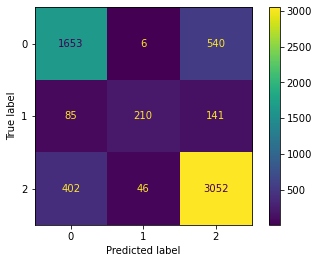

In [16]:
# Creating initial predictions
y_preds = mnb.predict(X_train_vec)
y_test_pred = mnb.predict(X_test_vec)
print("Training Accuracy:", accuracy_score(y_train, y_preds))
print("Training Recall:", recall_score(y_train, y_preds, average = 'macro'))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred, average = 'macro'))
cm = confusion_matrix(y_train, y_preds)
cmdisplay = ConfusionMatrixDisplay(cm)
cmdisplay.plot();

In [28]:
y_train

2132    2
2574    2
675     1
45      0
1621    2
       ..
5806    0
5981    2
962     0
8445    2
8072    1
Name: emotion, Length: 6135, dtype: int32

In [32]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

over = SMOTE(sampling_strategy = 'minority')
under = RandomUnderSampler(sampling_strategy=0.8)

X_smote, y_smote = under.fit(X_train, y_train)
X_test_smote, y_test_smote = under.fit_resample(X_test, y_test)

counter = Counter(y_train)
test_counter = Counter(y_test_smote)
print(counter)
print(test_counter)

ValueError: Expected 2D array, got 1D array instead:
array=['line th amp congress enter new appl store wrap around block sxsw'
 'one lone dude await ipad appl sxsw store link appl ipad sxsw tablet'
 'googl interest locat base tech indoor venu busi convent center etc tech need improv first sxsw'
 ...
 'usa today ipad make good use digit shortcut still look like newspap mention tapworthi sxsw'
 'may man sxsw without iphon'
 'googl possibl launch social media servic sxsw link'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Training Accuracy: 0.7819070904645476
Training Recall: 0.7059222495037116
Test Accuracy: 0.6339198435972629
Test Recall: 0.5532829669216075


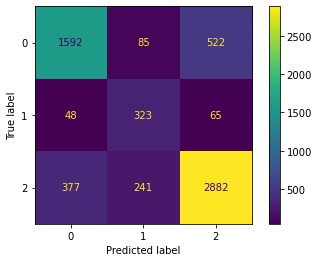

In [17]:
# Pipeline model for Multinomial Bayes + SMOTE
mnb_cv = imbpipeline(steps=[
    ('preprocess', CountVectorizer()),
    ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_cv.fit(X_train, y_train)

preds = mnb_cv.predict(X_train)
test_preds = mnb_cv.predict(X_test)
print("Training Accuracy:", mnb_cv.score(X_train, y_train))
print("Training Recall:", recall_score(preds, y_train, average = 'macro'))
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Recall:", recall_score(y_test, test_preds, average = 'macro'))
cm2 = confusion_matrix(y_train, preds)
cm2display = ConfusionMatrixDisplay(cm2)
cm2display.plot();

Training Accuracy: 0.7365933170334148
Training Recall: 0.7017686316036439
Test Accuracy: 0.5948191593352884
Test Recall: 0.5775158022029517


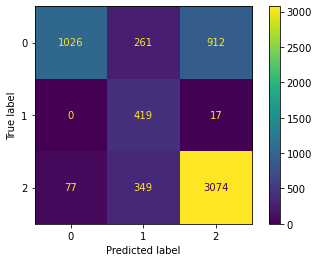

In [25]:
# Pipeline model to test if TfidfVectorizer is better than CountVectorizer
mnb_tfidf = imbpipeline(steps=[
    ('preprocess', TfidfVectorizer(lowercase = False)),
    ('SMOTE', SMOTE(sampling_strategy = 'minority', random_state = 42)),
    ('mnb', MultinomialNB())
])

mnb_tfidf.fit(X_train, y_train)
tfidf_preds = mnb_tfidf.predict(X_train)
tfidf_test_preds = mnb_tfidf.predict(X_test)
print("Training Accuracy:", mnb_tfidf.score(X_train, y_train))
print("Training Recall:", recall_score(tfidf_preds, y_train,average = 'macro'))
print("Test Accuracy:", accuracy_score(y_test, tfidf_test_preds))
print("Test Recall:", recall_score(y_test, tfidf_test_preds, average = 'macro'))
cm3 = confusion_matrix(y_train, tfidf_preds)
cm3display = ConfusionMatrixDisplay(cm3)
cm3display.plot();

Training Accuracy: 0.9300733496332518
Training Precision: 0.9132989529574883
Training Recall: 0.9579071718543428
Test Accuracy: 0.5948191593352884
Test Precision: 0.5420211108885639
Test Recall: 0.5775158022029517


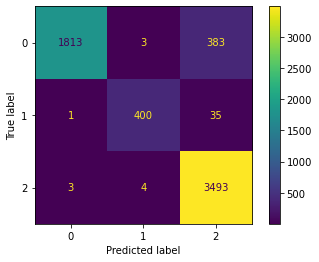

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_optimal_cv = imbpipeline(steps=[
    ('preprocess', TfidfVectorizer(lowercase = False, max_features=1500)),
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('rf', RandomForestClassifier(criterion = 'gini', n_estimators = 150,  max_depth = 50, 
                                  min_samples_leaf = 1, min_samples_split = 5, random_state=42))

])

rf_optimal_cv.fit(X_train, y_train)
tfidf_preds = rf_optimal_cv.predict(X_train)
# tfidf_test_preds = rf_optimal_cv.predict(X_test)

print("Training Accuracy:", rf_optimal_cv.score(X_train, y_train))
print("Training Precision:", precision_score(tfidf_preds, y_train, average = 'macro'))
print("Training Recall:", recall_score(tfidf_preds, y_train, average = 'macro'))

print("Test Accuracy:", accuracy_score(y_test, tfidf_test_preds))
print("Test Precision:", precision_score(y_test, tfidf_test_preds, average = 'macro'))
print("Test Recall:", recall_score(y_test, tfidf_test_preds, average = 'macro'))


cm4 = confusion_matrix(y_train, tfidf_preds)
cm4display = ConfusionMatrixDisplay(cm4)
cm4display.plot();